In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install optuna

In [3]:
import os

DIR = "/content/drive/MyDrive/Competitions/Signate/MUFG2023"
INPUT_DIR = os.path.join(DIR,"input")
OUTPUT_DIR = os.path.join(DIR,"output")
OOF_DIR = os.path.join(OUTPUT_DIR, 'oof')
SUB_NUM_DIR = os.path.join(OUTPUT_DIR, 'sub_num')

if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.metrics import mean_squared_error,  mean_absolute_percentage_error
from sklearn.metrics import f1_score, accuracy_score
import optuna

In [5]:
def get_f1_score(labels, outputs):
    y_pred = outputs
    y_true = labels
    best_score = 0
    best_thresh = 0.5
    for thresh in np.arange(0.1, 0.80, 0.01):
        thresh = np.round(thresh, 2)
        score = f1_score(y_true, (y_pred>thresh).astype(int))
        #print("Accuracy score at threshold {0} is {1}".format(thresh, score))
        if score > best_score:
          best_score = score
          best_thresh = thresh
    return f1_score(y_true, (y_pred>best_thresh).astype(int))

In [6]:
class CFG1:
  ver=18
  model="catboost"
  seed=42

class CFG2:
  ver=19
  model="lightgbm"
  seed=42

class CFG3:
  ver=20
  model="xgboost"
  seed=42

In [7]:
oof_df1 = pd.read_csv(os.path.join(OOF_DIR, f'oof_{CFG1.model}_ver{CFG1.ver}.csv'))
oof_df1.rename(columns={"pred":"pred1"},inplace=True)
oof_df2 = pd.read_csv(os.path.join(OOF_DIR, f'oof_{CFG2.model}_ver{CFG2.ver}.csv'))
oof_df2.rename(columns={"pred":"pred2"},inplace=True)
oof_df3 = pd.read_csv(os.path.join(OOF_DIR, f'oof_{CFG3.model}_ver{CFG3.ver}.csv'))
oof_df3.rename(columns={"pred":"pred3"},inplace=True)

In [8]:
oof_df = oof_df1.merge(oof_df2[["index","pred2"]], how="left", on="index").merge(oof_df3[["index","pred3"]], how="left", on="index")

oof_df["model1"] = oof_df["pred1"].values
oof_df["model2"] = oof_df["pred2"].values
oof_df["model3"] = oof_df["pred3"].values

In [9]:
preds_df = oof_df[["is_fraud?","model1","model2","model3"]].copy()
display(preds_df.corr())
print(preds_df.shape)
preds_df.dropna(axis=0,inplace=True)
print(preds_df.shape)
y_true = preds_df["is_fraud?"].values
preds_df.drop("is_fraud?",axis=1,inplace=True)

,is_fraud?,model1,model2,model3
is_fraud?,1.000000,0.709066,0.706214,0.686727
model1,0.709066,1.000000,0.955942,0.954919
model2,0.706214,0.955942,1.000000,0.948713
model3,0.686727,0.954919,0.948713,1.000000


(471283, 4)
(471283, 4)


In [10]:
for i in range(3):
  score = get_f1_score(y_true, preds_df[f"model{i+1}"])
  print(f"model{i} : {score}")

model0 : 0.672034188034188
model1 : 0.6709376042709377
model2 : 0.6451733514615908


In [11]:
SEED = 42
np.random.seed(SEED)

n_models = preds_df.shape[1]
max_iter = 150

In [12]:
def calc_f1_score(weight = np.ones(n_models)):
    y_pred_blended = np.average(preds_df, axis = 1, weights = weight)
    best_score = 0
    best_thresh = 0.5
    for thresh in np.arange(0.1, 0.801, 0.01):
        thresh = np.round(thresh, 2)
        score = f1_score(y_true, (y_pred_blended>thresh).astype(int))
        # print("F1 score at threshold {0} is {1}".format(thresh, score))
        if score > best_score:
          best_score = score
          best_thresh = thresh
    return f1_score(y_true, (y_pred_blended>best_thresh).astype(int))

In [13]:
class Objective:
    def __init__(self, n_models):
        self.n_models = n_models

    def __call__(self, trial):
        weight = [trial.suggest_uniform('weight' + str(n), 0, 1) for n in range(self.n_models)]
        return calc_f1_score(weight)
objective = Objective(n_models)

sampler = optuna.samplers.TPESampler(seed=SEED)
study = optuna.create_study(sampler = sampler,direction='maximize')
study.optimize(objective, n_trials = max_iter, n_jobs = -1)

[I 2023-08-25 13:25:59,074] A new study created in memory with name: no-name-2053028e-50c3-49ca-837e-7681eac61640
<ipython-input-13-97f94d2f71c2>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  weight = [trial.suggest_uniform('weight' + str(n), 0, 1) for n in range(self.n_models)]
[I 2023-08-25 13:26:34,949] Trial 0 finished with value: 0.6680393424769424 and parameters: {'weight0': 0.03595366365509234, 'weight1': 0.5827827977333763, 'weight2': 0.7490583689014761}. Best is trial 0 with value: 0.6680393424769424.
<ipython-input-13-97f94d2f71c2>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  weight = [trial.suggest_uniform('weight' + str(n), 0, 1) for n in range(self.n_models)]
[I 2023-08-25 13:26:35,227

In [14]:
best_weight = list(study.best_params.values())
best_weight = np.array(best_weight) / np.sum(best_weight)
best_score = study.best_value
print('best score: {0}\nbest weight: {1}'.format(best_score, best_weight))

best score: 0.6805185884777196
best weight: [5.07751964e-01 4.91988933e-01 2.59103578e-04]


In [15]:
oof_pred = preds_df["model1"]*best_weight[0] + preds_df["model2"]*best_weight[1] + preds_df["model3"]*best_weight[2]

In [16]:
best_score = 0
best_thresh = 0.5
for thresh in np.arange(0.15, 0.801, 0.01):
    thresh = np.round(thresh, 2)
    score = f1_score(y_true, (oof_pred>thresh).astype(int))
    print("F1 score at threshold {0} is {1}".format(thresh, score))
    if score > best_score:
      best_score = score
      best_thresh = thresh
print()
print("best F1 score at threshold {0} is {1}".format(best_thresh, f1_score(y_true, (oof_pred>best_thresh).astype(int))))

F1 score at threshold 0.15 is 0.6315621084064307
F1 score at threshold 0.16 is 0.6396133154919578
F1 score at threshold 0.17 is 0.6457688122541224
F1 score at threshold 0.18 is 0.6513984769767275
F1 score at threshold 0.19 is 0.6557838119953028
F1 score at threshold 0.2 is 0.6607200778462536
F1 score at threshold 0.21 is 0.6647987773815589
F1 score at threshold 0.22 is 0.6672644376899696
F1 score at threshold 0.23 is 0.6699757981224277
F1 score at threshold 0.24 is 0.6726183044075416
F1 score at threshold 0.25 is 0.6744898603828416
F1 score at threshold 0.26 is 0.6761143952708101
F1 score at threshold 0.27 is 0.6775912173070714
F1 score at threshold 0.28 is 0.6783139212423739
F1 score at threshold 0.29 is 0.678860115568872
F1 score at threshold 0.3 is 0.6792716156044394
F1 score at threshold 0.31 is 0.6790909700341891
F1 score at threshold 0.32 is 0.6798539257455872
F1 score at threshold 0.33 is 0.6799938647170101
F1 score at threshold 0.34 is 0.6805185884777196
F1 score at threshold 0

In [17]:
class CFG:
  ver=22
  model="blending"

In [18]:
test_pred1 = pd.read_csv(os.path.join(SUB_NUM_DIR, f'submit_num_{CFG1.model}_ver{CFG1.ver}.csv'),header=None)[1]
test_pred2 = pd.read_csv(os.path.join(SUB_NUM_DIR, f'submit_num_{CFG2.model}_ver{CFG2.ver}.csv'),header=None)[1]
test_pred3 = pd.read_csv(os.path.join(SUB_NUM_DIR, f'submit_num_{CFG3.model}_ver{CFG3.ver}.csv'),header=None)[1]

,0,1
0,471283,0
1,471284,0
2,471285,0
3,471286,1
4,471287,0


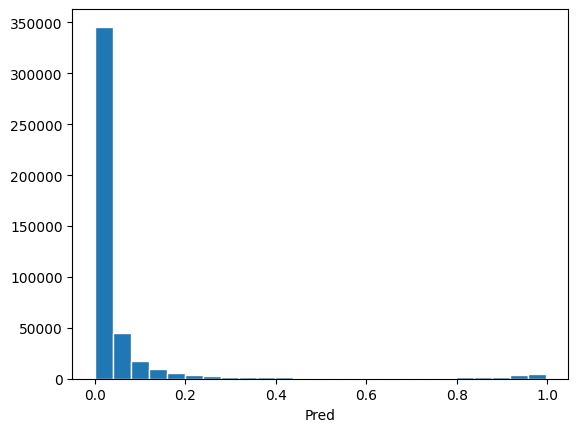

,0,1
0,471283,0
1,471284,0
2,471285,0
3,471286,1
4,471287,0
...,...,...
457953,929236,0
457954,929237,0
457955,929238,0
457956,929239,0


In [19]:
submit = pd.read_csv(os.path.join(INPUT_DIR,"sample_submit.csv"), header=None)
pred = test_pred1*best_weight[0] + test_pred2*best_weight[1] - test_pred3*best_weight[2]
submit[1] = (pred>best_thresh).astype(int)

submit.to_csv(os.path.join(OUTPUT_DIR, f'submit_{CFG.model}_ver{CFG.ver}.csv'), index=False, header=None)
display(submit.head())

plt.hist(pred,bins=25,edgecolor='white')
plt.xlabel("Pred")
plt.show()

display(submit)